In [1]:
#Import Relevant Modules
import re
from datetime import datetime, date
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
#Retrive today's date
date = date.today()

In [3]:
def getPressureData(filename):
    '''
    Extract pressure data from txt file

    @param:
        filename -> str
    
    @return:
        2D list of Time and Pressure -> list
    '''
    
    data = []                          
    pressure_pattern = re.compile(r'\[(\d{2}:\d{2}:\d{2})\].*?pressure:\s*([0-9.]+E[-+]?\d+)', re.I)
    
    with open(filename, "r") as f:
        for line in f:
            p = pressure_pattern.search(line)
            if p:
                time_str = p.group(1)
                pressure = p.group(2)
                log_time = datetime.strptime(time_str, "%H:%M:%S").time()

                data.append((log_time, pressure))
    return data

In [4]:
def getPMONData(filename):
    '''
    Extract PMON Temperature data from txt file

    @param:
        filename -> str
    @return:
        list with data from each PMON
    '''
    
    data = [] 
    pmon_pattern = re.compile(r'\[(\d{2}:\d{2}:\d{2})\].*?PMON\s+temps:\s*(\{[^}]+\})', re.I)
    with open(filename, "r") as f:
        for line in f:
            p = pmon_pattern.search(line)
            if p:
                time_str = p.group(1)
                log_time = datetime.strptime(time_str, "%H:%M:%S").time()
                
                pmon_dict = eval(p.group(2))
                pmon_1 = pmon_dict[1]
                pmon_2 = pmon_dict[2]
                pmon_3 = pmon_dict[3]
                pmon_4 = pmon_dict[4]
                pmon_5 = pmon_dict[5]
                pmon_6 = pmon_dict[6]

                data.append((log_time, pmon_1, pmon_2, pmon_3, pmon_4, pmon_5, pmon_6))
    return data

In [5]:
def createPressureCSV(pressure_data):
    '''

    @param:
    pressure_data: list of data -> list
    '''
    if not (os.path.exists(f'pressure_log-{str(date)}.csv')):
        #Using 'w' to overwrite existing
        with open(f'pressure_log-{str(date)}.csv', 'w', newline='') as out:
            writer = csv.writer(out)
            writer.writerow(['Time', 'Pressure (mbar)'])   # header
            writer.writerows(pressure_data)
        print(f'{len(pressure_data)} rows written to pressure_log-{str(date)}.csv')
    else :
        print(f'pressure_log-{str(date)}.csv already exists')

In [ ]:
def createPMONCSV(pmon_data):
    '''

    '''
    if not (os.path.exists(f'pmon_log-{str(date)}.csv')):
        with open(f'pmon_log-{str(date)}.csv', 'w', newline='') as out:
            writer = csv.writer(out)
            writer.writerow(['Time', 'PMON 1 (°C)', 'PMON_2 (°C)', 'PMON_3 (°C)', 'PMON_4 (°C)', 'PMON_5 (°C)', 'PMON_6 (°C)'])   # header
            writer.writerows(pmon_data)

        print(f'{len(pmon_data)} rows written to pmon_log-{str(date)}.csv')
    else:
        print(f'pmon_log-{str(date)}.csv already exists')

In [7]:
def getPressureGraph(csv_file, start_time='00:00:01', end_time='23:59:59', time_list = []):
    '''
    Displays Pressure Graph

    @param:
        csv_file : File Name -> str
        start_time : -> str
        end_time : -> str
    
    '''
    result = pd.read_csv(csv_file)

    data = result.to_numpy()

    #Check if time exists to provide warning
    if (result.loc[result['Time'] == start_time]).empty:
        print("Start Time does not exist, using default start time")

    if (result.loc[result['Time'] == end_time]).empty:
        print("End Time does not exist, using default end time")

    # Filter by time range
    filtered = result[(result['Time'] >= start_time) & (result['Time'] <= end_time)]
    average = filtered.iloc[:,1].to_numpy().mean()

    
    highlight = result[result['Time'].isin(time_list)]
    print(highlight) 
    

    fig = plt.figure(figsize=(12,10))
    gs = fig.add_gridspec(4,1)

    ax1 = fig.add_subplot(gs[:3,0])
    ax1.plot(filtered['Pressure (mbar)'].to_numpy(), label = 'Pressure')
    ax1.scatter(highlight['Time'], highlight['Pressure (mbar)'],  color='red', label='High Pressure')
    ax1.grid()
    ax1.set_title('Pressure x Time')
    ax1.set_xlabel("Time Elapsed (s)")
    ax1.set_ylabel("Pressure mbar (E-6)")

    plt.show()

           Time  Pressure (mbar)
19911  16:35:00     6.120000e-07
19912  16:35:00     6.120000e-07
20460  16:40:00     6.500000e-07
21227  16:47:00     6.670000e-07
21228  16:47:00     6.680000e-07


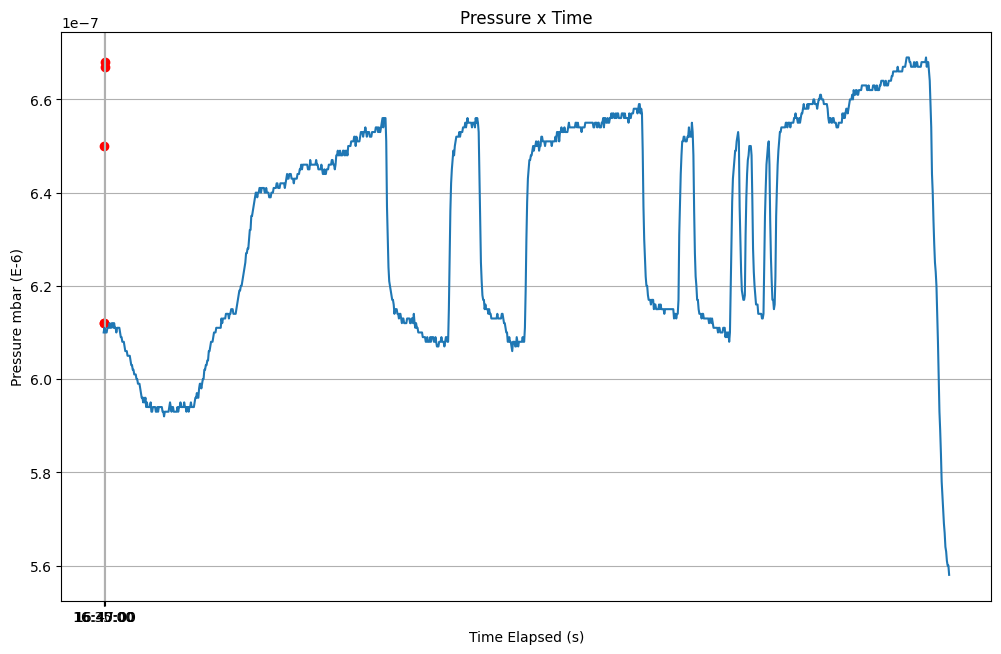

In [9]:
getPressureGraph(f'pressure_log-2025-06-10.csv','16:37:00','16:47:20',['16:35:00', '16:40:00', '16:47:00'])

In [10]:
def getPMONGraph(csv_file, start_time = '00:00:01', end_time = '23:59:59'):
    '''
    Displays PMON Graph

    args:
        csv_file : File name -> str
        start_time : -> str
    
    '''
    pmon_result = pd.read_csv(csv_file)
    pmon_result = pmon_result.to_numpy()
    time_DNE = False

    time = pmon_result[:,0]
    pmon_data = {}

    try:
        start_index = time.tolist().index(str(start_time))
        end_index = time.tolist().index(str(end_time))
    except ValueError:
        print("Timeframe does not exist")
        time_DNE = True

    ports = {1:'PMON_1', 2:'PMON_2', 3:'PMON_3', 4:'PMON_4', 5:'PMON_5', 6:'PMON_6'}

    for idx, value in ports.items():
        if time_DNE == True:
            pmon_data[value] = pmon_result[:, idx].tolist()
        elif time_DNE == False:
            pmon_data[value] = pmon_result[start_index:end_index, idx].tolist()

    #Method 1 - Completely remove the disconnected value (data will be shorter than the rest)
    #for key in ports.values():
    #    pmon_data[key] = [float(x) for x in pmon_data[key] if x not in ('DISCONNECTED','SENSOR_ERROR')]

    #Method 2 - fill data points that are disconnected with previous value
    for key in ports.values():
        if pmon_data[key][0] in ['DISCONNECTED','SENSOR_ERROR', 'None']:
            pmon_data[key] = [float(x) for x in pmon_data[key] if x not in ('DISCONNECTED','SENSOR_ERROR', 'None')]
        else:
            for i in range(len(pmon_data[key])):
                if pmon_data[key][i] in ['DISCONNECTED','SENSOR_ERROR','None']:
                    pmon_data[key][i] = pmon_data[key][i - 1]
            pmon_data[key] = [float(x) for x in pmon_data[key]]


    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot()
    
    for key in ports.values():
        if pmon_data[key]:
            print(f'Average Temperature for {key}: {np.mean(pmon_data[key])}')
        else:
            print(f'No data from {key}')
        ax.plot(pmon_data[key], label=key)
    
    ax.set_xlabel('Time Elapsed (s)')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Temperature Graph')
    ax.grid()
    ax.legend(loc='upper right')
    plt.show()


In [ ]:
createPressureCSV(getPressureData('log_export_2025-06-09_17-10-43.txt'))

23856 rows written to pressure_log-2025-06-09.csv


In [14]:
createPMONCSV(getPMONData("log_export_2025-06-09_17-10-43.txt"))

24108 rows written to pmon_log-2025-06-10.csv


Empty DataFrame
Columns: [Time, Pressure (mbar)]
Index: []


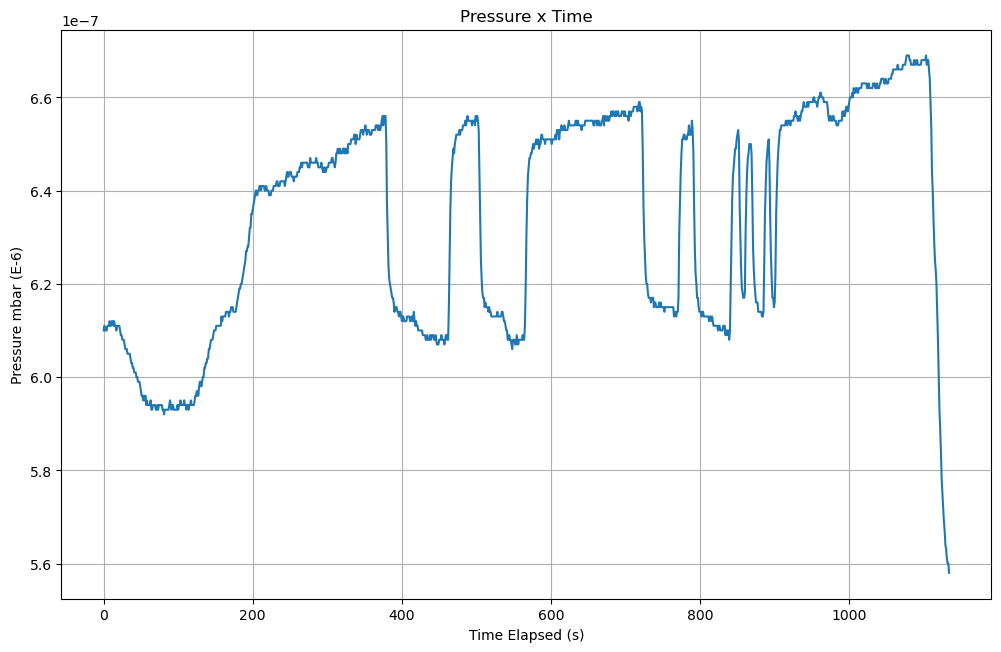

In [ ]:
getPressureGraph(f'pressure_log-{date}.csv','16:37:00','16:47:20')

In [15]:
getPMONGraph(f'pmon_log-{str(date)}.csv')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 13: invalid start byte